In [119]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler, OneHotEncoder, PolynomialFeatures
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import classification_report, accuracy_score
import matplotlib.pyplot as plt





In [120]:
# 1. Laden der Daten
data = pd.read_csv("../../../data/predictive_maintenance.csv")

In [121]:
data.columns

Index(['UDI', 'Product ID', 'Type', 'Air temperature [K]',
       'Process temperature [K]', 'Rotational speed [rpm]', 'Torque [Nm]',
       'Tool wear [min]', 'Target', 'Failure Type'],
      dtype='object')

In [122]:
data.sample()

,UDI,Product ID,Type,Air temperature [K],Process temperature [K],Rotational speed [rpm],Torque [Nm],Tool wear [min],Target,Failure Type
3471,3472,L50651,L,301.8,310.7,1441,49.3,58,0,No Failure


In [123]:

# 2. Encoding der kategorialen Variablen und Skalierung der Features
categorical_features = ['Type']
numerical_features = data.select_dtypes(include=[np.number]).columns.tolist()
numerical_features.remove('UDI')
numerical_features.remove('Target')

# Feature Engineering: Polynomial Features
poly = PolynomialFeatures(degree=2, include_bias=False)

preprocessor = ColumnTransformer(
    transformers=[
        ('num', Pipeline(steps=[
            ('scaler', StandardScaler()),
            ('poly', poly)
        ]), numerical_features),
        ('cat', OneHotEncoder(), categorical_features)
    ])



In [124]:
data.dtypes

UDI                          int64
Product ID                  object
Type                        object
Air temperature [K]        float64
Process temperature [K]    float64
Rotational speed [rpm]       int64
Torque [Nm]                float64
Tool wear [min]              int64
Target                       int64
Failure Type                object
dtype: object

In [125]:
data.columns

Index(['UDI', 'Product ID', 'Type', 'Air temperature [K]',
       'Process temperature [K]', 'Rotational speed [rpm]', 'Torque [Nm]',
       'Tool wear [min]', 'Target', 'Failure Type'],
      dtype='object')

In [126]:
# 3. Aufteilung der Daten in Trainings- und Testdatensätze
X = data[numerical_features + categorical_features]  # select Features 
y = data["Failure Type"]

In [127]:
X.head()

,Air temperature [K],Process temperature [K],Rotational speed [rpm],Torque [Nm],Tool wear [min],Type
0,298.1,308.6,1551,42.8,0,M
1,298.2,308.7,1408,46.3,3,L
2,298.1,308.5,1498,49.4,5,L
3,298.2,308.6,1433,39.5,7,L
4,298.2,308.7,1408,40.0,9,L


In [128]:
y.head()

0    No Failure
1    No Failure
2    No Failure
3    No Failure
4    No Failure
Name: Failure Type, dtype: object

In [129]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [130]:
# Überprüfen der Pipeline
X_train_transformed = preprocessor.fit_transform(X_train)
X_test_transformed = preprocessor.transform(X_test)

print(X_train_transformed.shape)
print(X_test_transformed.shape)



(8000, 23)
(2000, 23)


In [131]:
# 4. Training des GradientBoosting-Modells mit Hyperparameter-Tuning
model = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', GradientBoostingClassifier())
])

model.fit(X_train, y_train)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('scaler',
                                                                   StandardScaler()),
                                                                  ('poly',
                                                                   PolynomialFeatures(include_bias=False))]),
                                                  ['Air temperature [K]',
                                                   'Process temperature [K]',
                                                   'Rotational speed [rpm]',
                                                   'Torque [Nm]',
                                                   'Tool wear [min]']),
                                                 ('cat', OneHotEncoder(),
                                                  ['Type'])])),
                ('classifier', GradientBoostingClassifier())])

In [132]:
# 5. Evaluierung des Modells
y_pred = model.predict(X_test)

accuracy = accuracy_score(y_test, y_pred)
classification_rep = classification_report(y_test, y_pred)

print("Accuracy:", accuracy)
print("Classification Report:\n", classification_rep)


Accuracy: 0.977
Classification Report:
                           precision    recall  f1-score   support

Heat Dissipation Failure       0.67      0.80      0.73        15
              No Failure       0.99      0.99      0.99      1935
      Overstrain Failure       0.78      0.54      0.64        13
           Power Failure       0.80      0.80      0.80        20
         Random Failures       0.00      0.00      0.00         6
       Tool Wear Failure       0.00      0.00      0.00        11

                accuracy                           0.98      2000
               macro avg       0.54      0.52      0.53      2000
            weighted avg       0.97      0.98      0.97      2000



### Confusion Matrix

In [133]:
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import seaborn as sns

In [135]:
error_names = [
 'Heat Failure',
 'No Failure',
 'Overstrain Failure',
 'Power Failure',
 'Random Failure',
 'Tool wear Failure']

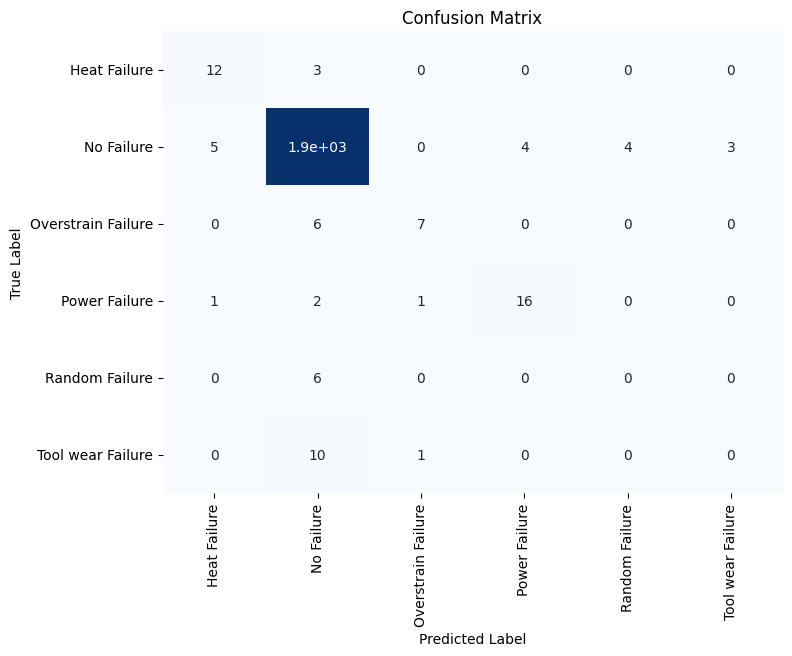

In [136]:
conf_matrix = confusion_matrix(y_test, y_pred)

plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, cmap="Blues", cbar=False, xticklabels=error_names, yticklabels=error_names)
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix")
plt.show()

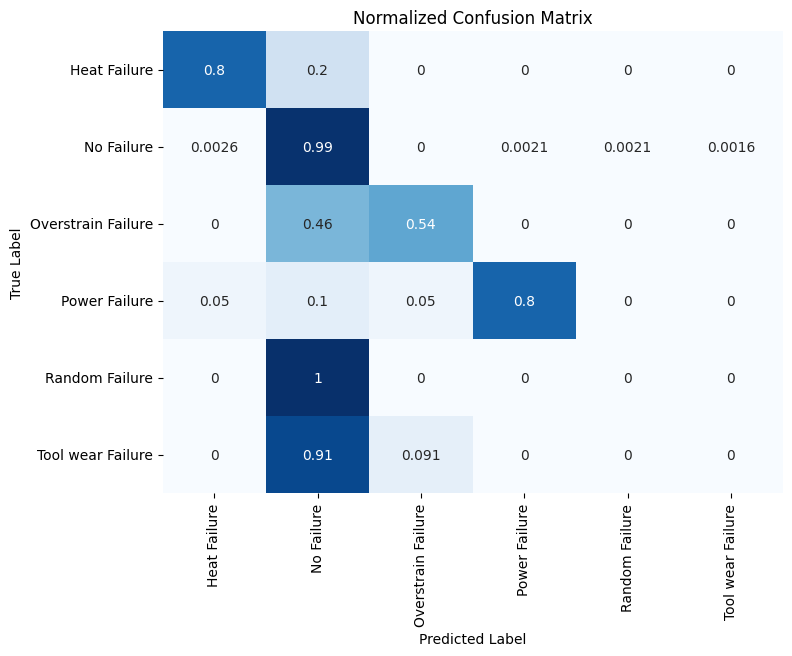

In [137]:
conf_matrix_normalized = confusion_matrix(y_test, y_pred, normalize='true')

plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix_normalized, annot=True, cmap="Blues", cbar=False, xticklabels=error_names, yticklabels=error_names)
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Normalized Confusion Matrix")
plt.show()